# Fine-tuning and transfer learning

## Fine-Tune VGG16 Image Classifier With Keras | Part 1:


### VGG16 And ImageNet

* The pre-trained model we'll be working with to classify images of cats and dogs is called VGG16, which is the model that won the 2014 ImageNet competition.

* In the ImageNet competition, multiple teams compete to build a model that best classifies images from the ImageNet library. The ImageNet library houses thousands of images belonging to 1000 different categories.

* We’ll import this VGG16 model and then fine-tune it using Keras. The fine-tuned model will not classify images as one of the 1000 categories for which it was trained on, but instead it will only work to classify images as either cats or dogs.

* Note that dogs and cats were included in the ImageNet library from which VGG16 was originally trained. Therefore, the model has already learned the features of cats and dogs. Given this, the fine-tuning we'll do on this model will be very minimal. In later episodes, we'll do more involved fine-tuning and utilize transfer learning to classify completely new data than what was included in the training set.


### Building A Fine-Tuned Model


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense,Flatten , BatchNormalization , Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

import the VGG16 model from Keras. 

In [2]:
vgg16_model = tf.keras.applications.vgg16.VGG16()

553467904/553467096 [==============================] - 2595s 5us/step


The original trained VGG16 model, along with its saved weights and other parameters, is now downloaded onto our machine.

In [3]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Notice that the last Dense layer of VGG16 has 1000 outputs. These outputs correspond to the 1000 categories in the ImageNet library.

Since we’re only going to be classifying two categories, cats and dogs, we need to modify this model in order for it to do what we want it to do, which is to only classify cats and dogs.

In [4]:
type(vgg16_model)

tensorflow.python.keras.engine.training.Model

**vgg16_model is a Model is of type model. So we will convert it to sequential model.**


We first create a new model of type Sequential. We then iterate over each of the layers in vgg16_model, except for the last layer, and add each layer to the new Sequential model.

In [5]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

Iterate over each of the layers in our new Sequential model and set them to be non-trainable. This freezes the weights and other trainable parameters in each layer so that they will not be trained or updated when we later pass in our images of cats and dogs.

In [6]:
for layer in model.layers:
    layer.trainable = False

**The reason we don’t want to retrain these layers is because, as mentioned earlier, cats and dogs were already included in the original ImageNet library. So, VGG16 already does a nice job at classifying these categories. We only want to modify the model such that the output layer understands only how to classify cats and dogs and nothing else. Therefore, we don’t want any re-training to occur on the earlier layers.**


Add our new output layer, consisting of only 2 nodes that correspond to cat and dog. This output layer will be the only trainable layer in the model.

In [7]:
model.add(Dense(units=2, activation='softmax'))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

We will notice that the new model is same as the original vgg16_model, xcept for now, the output layer has only 2 nodes, rather than 1000, and the number of trainable parameters has drastically decreased since we froze all the parameters in the earlier layers.

## Fine-Tune VGG16 Image Classifier With Keras | Part 2: Train

In [9]:
train_path = 'data/dogs-vs-cats/train'
valid_path = 'data/dogs-vs-cats/valid'
test_path = 'data/dogs-vs-cats/test'


In [10]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10, shuffle=False)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


### Complie the model

Use the Adam optimizer with a learning rate of 0.0001,categorical_crossentropy as our loss, and ‘accuracy’ as our metric.


In [11]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

### Train the Model

In [12]:
model.fit(x=train_batches,
          steps_per_epoch=len(train_batches),
          validation_data=valid_batches,
          validation_steps=len(valid_batches),
          epochs=5,
          verbose=2
)

Epoch 1/5
100/100 - 500s - loss: 0.2740 - accuracy: 0.8890 - val_loss: 0.1788 - val_accuracy: 0.9350
Epoch 2/5
100/100 - 570s - loss: 0.0803 - accuracy: 0.9710 - val_loss: 0.1323 - val_accuracy: 0.9500
Epoch 3/5
100/100 - 519s - loss: 0.0481 - accuracy: 0.9820 - val_loss: 0.1338 - val_accuracy: 0.9600
Epoch 4/5
100/100 - 289s - loss: 0.0329 - accuracy: 0.9920 - val_loss: 0.1245 - val_accuracy: 0.9600
Epoch 5/5
100/100 - 288s - loss: 0.0231 - accuracy: 0.9950 - val_loss: 0.1115 - val_accuracy: 0.9550


## Fine-Tune VGG16 Image Classifier With Keras | Part 3: Predict

In [14]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

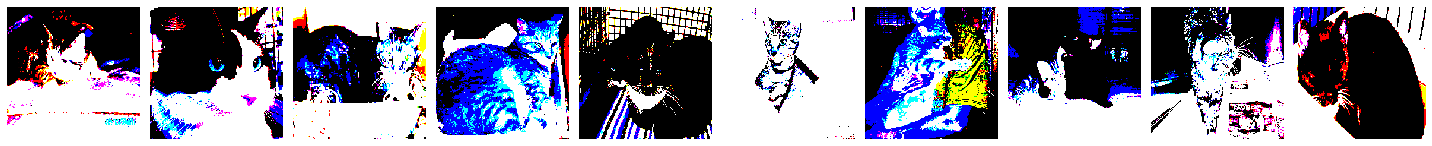

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [15]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

model.predict to have the model predict on the test data.

In [16]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

### Plot Predictions With A Confusion Matrix

In [17]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))
cm_plot_labels = ['cat','dog']

In [18]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[49  1]
 [ 0 50]]


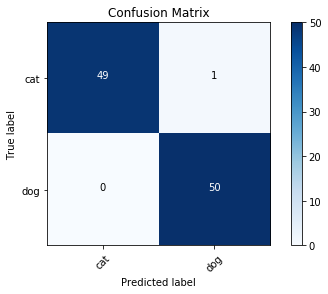

In [19]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

We can see that the model incorrectly predicted only 1 samples out of 100. This gives us 99% accuracy on the test set, proving this model to be much more capable of generalizing than the previous CNN we built from scratch.